# Examine the geographical distance dependence of latency

I've pinged websites of different universities around the world as it was advised in the task description. To measure the latency of websites to each university I used a custom ping command to send a specific number of (50) packages to universities with 32 bytes of data each per second.

I downloaded the [following dataset](https://searchenginesmarketer.com/company/resources/university-college-list/), which lists names, locations and websites of the top, mostly US universities.

In [124]:
import os
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
inputs = './data/uni_lists/'
data = './data/universities/'

### Just some matplotlib and seaborn parameter tuning

In [375]:
fig_x = 30
fig_y = 11
axistitlesize = 22
axisticksize = 18
axislabelsize = 30
axistextsize = 14
axislegendsize = 25
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

In [4]:
os.listdir(inputs)

['school_and_country_table.csv', 'university_sites.csv']

## 1. Gather university data

In [207]:
df = pd.read_csv(inputs + 'university_sites.csv')
df = df.drop_duplicates('School Name')
df = df[~(df['City'] == '(multiple locations)')]
df['URL'] = df['URL'].apply(lambda x: x.split('//')[1].strip('/'))

In [226]:
display(df.head())
display(df.tail())

,School Name,URL,City,State
0,University of Alaska,alaska.edu,Anchorage,AK
1,Alaska Christian College,alaskacc.edu,Soldotna,AK
2,National Park Community College,npcc.edu,Hot Springs National Park,AK
3,University of Alaska Fairbanks,uaf.edu,Fairbanks,AK
4,University of Arkansas - Fort Smith,uafs.edu,Fort Smith,AK


,School Name,URL,City,State
1925,Central Wyoming College,cwc.edu,Riverton,WY
1926,National Outdoor Leadership School,nols.edu,Lander,WY
1927,Northwest College,northwestcollege.edu,Powell,WY
1928,Northern Wyoming Community College District,sheridan.edu,Sheridan,WY
1929,University of Wyoming,uwyo.edu,Laramie,WY


### Add locational data

In [145]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='ping')

In [177]:
cities = list(df['City'])
states = list(df['State'])
lat = []
long = []
pbar = tqdm(cities)
for c in pbar:
    #c, s = cities[i], states[i]
    pbar.set_description("Processing %s" % c)
    loc = geolocator.geocode(c)#'{0}, {1}'.format(c,s))
    if type(loc) != type(None):
        lat.append(loc.latitude)
        long.append(loc.longitude)
    else:
        lat.append(0)
        long.append(0)

Processing Laramie: 100%|██████████| 1861/1861 [15:30<00:00,  2.00it/s]               


In [181]:
def haversine(X, Y, x_0=0, y_0=0,
              R=1):
    """
    Calculates the Haversine formula for every point on a given
    domain by considering R = 1 by default.
    
    Parameters
    ----------
    X : numpy.ndarray
        X coordinates of the domain.
    Y : numpy.ndarray
        Y coordinates of the domain.
    
    Returns
    -------
    d : numpy.ndarray
        Distance matrix of the grid of the input domain.
    """
    d = 2 * R * np.arcsin(np.sqrt(np.sin((X - x_0)/2)**2 + np.cos(X) * np.cos(x_0) * np.sin((Y - y_0)/2)**2))
    
    return d

In [261]:
# Create a copy of the old array for reusability
df_n = df.copy()

lat_arr = np.array(lat)
long_arr = np.array(long)
# Add coordinates to 
df_n['Latitude'] = lat_arr
df_n['Longitude'] = long_arr

# Create a mask for faulty entries
bad_coord_mask = (lat_arr == 0)
# Drop rows with lat, long == 0
df_n = df_n[~bad_coord_mask]
# Calculate distance from Budapest
# X: latitude, Y: longitude
df_n['Distance'] = haversine(X=np.deg2rad(df_n['Latitude']),
                             Y=np.deg2rad(df_n['Longitude']),
                             x_0=np.deg2rad(47.497913),
                             y_0=np.deg2rad(19.040236),
                             R=6378000)

df_n = df_n.reset_index(drop=True)

In [262]:
display(df_n.head())
display(df_n.tail())

,School Name,URL,City,State,Latitude,Longitude,Distance
0,University of Alaska,alaska.edu,Anchorage,AK,61.216313,-149.894852,7.894558e+06
1,Alaska Christian College,alaskacc.edu,Soldotna,AK,60.484723,-151.065349,7.983538e+06
2,National Park Community College,npcc.edu,Hot Springs National Park,AK,34.518020,-93.052942,8.679530e+06
3,University of Alaska Fairbanks,uaf.edu,Fairbanks,AK,64.837845,-147.716675,7.479422e+06
4,University of Arkansas - Fort Smith,uafs.edu,Fort Smith,AK,35.387222,-94.424898,8.684646e+06


,School Name,URL,City,State,Latitude,Longitude,Distance
1854,Central Wyoming College,cwc.edu,Riverton,WY,40.687001,-95.568169,8.292703e+06
1855,National Outdoor Leadership School,nols.edu,Lander,WY,39.905988,-116.984337,9.379627e+06
1856,Northwest College,northwestcollege.edu,Powell,WY,46.910957,-113.029419,8.543818e+06
1857,Northern Wyoming Community College District,sheridan.edu,Sheridan,WY,39.353060,-100.457646,8.667462e+06
1858,University of Wyoming,uwyo.edu,Laramie,WY,41.311367,-105.591101,8.745336e+06


### Ping addresses

In [270]:
n_packet = 50
packet_size = 32
interval = 1

In [278]:
%%time
# Takes lot of time to write all files and ping all sites!
for target in df_n['URL']:
    ping_command = 'ping -D -c {0} -i {1} -s {2} {3}'.format(n_packet, interval, packet_size, target)
    output = "{0}{1}.txt".format(data, target)
    with open(output, 'w') as f:
        # Using `Popen` here to run pings "parallel"
        #print('Pinging {}...'.format(target))
        process = subprocess.Popen(ping_command.split(' '), stdout=f)

CPU times: user 3.34 s, sys: 30.3 s, total: 33.7 s
Wall time: 44.2 s


There are hunderds of URLs in this list, which simply cannot be pinged, or cannot be reached.

## 2. Preprocess data

### Read ping files

In [314]:
def read_ping_file(file_name):
    
    dc = []
    with open(data + file_name, 'r') as f:
        header = f.readline()
        if header != '':
            print(header)
        for i, line in enumerate(f):
            # Skip faulty lines
            if\
            ('unreachable' in line.lower()
             or
             'packet filtered' in line.lower()
             or
             'time to live exceeded' in line.lower()
             or
             'destination host prohibited' in line.lower()
            ):
                continue
            if line == '\n':
                break
            line = line.replace(' (DUP!)', '')
            elems = line.split(' ')
            try:
                ts = float(elems[0].strip('[]'))        # Unix timestamp
                ts = datetime.utcfromtimestamp(ts)      # Create datetime values
                b = float(elems[1])                     # Packet size used to ping host
                h = header.split(' ')[1]                # Pinged host's name
                hip = header.split(' ')[2].strip('()')  # Pinged host's IP address
                p = float(elems[-2].strip('time='))     # Ping in ms
                dc.append([ts, b, h, hip, p])
            except:
                print(line)
    df = pd.DataFrame(data=dc, columns=['Timestamp',
                                        'Packet size [byte]',
                                        'Host name',
                                        'Host IP',
                                        'Ping [ms]'])
    return df, header

In [315]:
dfs = {}
headers = [{}]
urls = []

for i, file in enumerate(sorted(os.listdir(data))):
    df_c, header_c = read_ping_file(file_name=file)
    dfs[file.strip('.txt')] = df_c
    headers[file.strip('.txt')] = header_c

PING aacc.edu (136.160.248.44) 32(60) bytes of data.

PING aamu.edu (198.180.132.26) 32(60) bytes of data.

PING acu.edu (54.83.114.120) 32(60) bytes of data.

PING adelphi.edu (192.147.12.33) 32(60) bytes of data.

PING agnesscott.edu (4.21.22.162) 32(60) bytes of data.

PING aimc.edu (35.222.133.70) 32(60) bytes of data.

PING aims.edu (205.169.249.2) 32(60) bytes of data.

PING alamancecc.edu (104.198.48.60) 32(60) bytes of data.

PING alamo.edu (34.236.161.60) 32(60) bytes of data.

PING alaska.edu (137.229.114.150) 32(60) bytes of data.

PING alaskacc.edu (35.209.241.207) 32(60) bytes of data.

PING albany.edu (18.216.105.254) 32(60) bytes of data.

PING albertus.edu (192.185.22.241) 32(60) bytes of data.

PING albion.edu (147.124.1.89) 32(60) bytes of data.

PING alcorn.edu (50.56.64.4) 32(60) bytes of data.

PING alma.edu (192.101.250.45) 32(60) bytes of data.

PING alverno.edu (159.203.174.156) 32(60) bytes of data.

PING alvincollege.edu (69.63.130.123) 32(60) bytes of data.



In [340]:
# Example
display(dfs['aamu.edu'].head())
display(dfs['aamu.edu'].tail())

,Timestamp,Packet size [byte],Host name,Host IP,Ping [ms]
0,2020-12-13 12:31:08.255658,40.0,aamu.edu,198.180.132.26,126.0
1,2020-12-13 12:31:09.255662,40.0,aamu.edu,198.180.132.26,126.0
2,2020-12-13 12:31:10.257324,40.0,aamu.edu,198.180.132.26,126.0
3,2020-12-13 12:31:21.266617,40.0,aamu.edu,198.180.132.26,126.0
4,2020-12-13 12:31:21.394773,40.0,aamu.edu,198.180.132.26,126.0


,Timestamp,Packet size [byte],Host name,Host IP,Ping [ms]
45,2020-12-13 12:33:52.658352,40.0,aamu.edu,198.180.132.26,126.0
46,2020-12-13 12:34:03.666026,40.0,aamu.edu,198.180.132.26,125.0
47,2020-12-13 12:34:03.794188,40.0,aamu.edu,198.180.132.26,126.0
48,2020-12-13 12:34:04.794499,40.0,aamu.edu,198.180.132.26,125.0
49,2020-12-13 12:34:05.794645,40.0,aamu.edu,198.180.132.26,126.0


In [366]:
# Select the pre-final set of indeces, where locational
# data is available, also the host could be at least reached
final_idx = np.where(np.array(list(headers.values())) != '')[0]

In [367]:
# Create a copy of the old array for reusability
df_f = df_n.copy()

# Create the final dataframe containing only the
# usable rows
df_f = df_f.iloc[final_idx]

In [368]:
display(df_f.head())
display(df_f.tail())

,School Name,URL,City,State,Latitude,Longitude,Distance
0,University of Alaska,alaska.edu,Anchorage,AK,61.216313,-149.894852,7.894558e+06
1,Alaska Christian College,alaskacc.edu,Soldotna,AK,60.484723,-151.065349,7.983538e+06
4,University of Arkansas - Fort Smith,uafs.edu,Fort Smith,AK,35.387222,-94.424898,8.684646e+06
6,Athens State University,athens.edu,Athens,AL,37.983941,23.728305,1.125735e+06
9,Birmingham-Southern College,bsc.edu,Birmingham,AL,52.479699,-1.902691,1.591240e+06


,School Name,URL,City,State,Latitude,Longitude,Distance
1842,Marshall University,marshall.edu,Huntington,WV,38.419250,-82.445154,7.719307e+06
1844,Pierpont Community and Technical College,pierpont.edu,Fairmont,WV,43.652178,-94.461083,7.981548e+06
1845,Shepherd University,shepherd.edu,Shepherdstown,WV,39.430100,-77.804161,7.351611e+06
1848,Wheeling Jesuit University,wju.edu,Wheeling,WV,42.138889,-87.931094,7.748764e+06
1849,West Virginia Northern Community College,wvncc.edu,Wheeling,WV,42.138889,-87.931094,7.748764e+06


### Add ping mean values to final dataframe

In [369]:
pings = []
for url in df_f['URL']:
    try:
        pings.append(dfs[url]['Ping [ms]'].mean())
    except:
        pings.append(0)
df_f['Ping [ms]'] = pings
# There are still rows, which belons to hosts, that could be reached,
# but didn't give any response because of various reasons.
# These entries should be dropped also, sadly.
df_f = df_f.dropna(how='any')
df_f = df_f[(df_f['Ping [ms]'] != 0)]

### Create appropriate date ticks

In [355]:
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.ticker as plticker

## 3. Visualize distance dependence of latency

In [383]:
def visualize_distance_ping(df, base=5.0):
    
    fig, axes = plt.subplots(figsize=(fig_x,fig_y),
                             facecolor='black', subplot_kw={'facecolor' : 'black'})
    
    sr = 8
    x = df['Distance']
    y = df['Ping [ms]']
    c = cm.magma(y/y.max()/2 + 0.5)
    axes.scatter(x/1000, y,
                 c=c, ec='None', alpha=0.4, s=sr**2)
    
    # X ticks denoting Distance    
    axes.set_xlabel('Distance [km]', fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='x', which='major', labelsize=axisticksize,
                     colors='white', pad=10, labelrotation=42)
    
    # Y ticks denoting ping in [ms]
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    axes.yaxis.set_major_locator(loc)
    axes.set_ylabel('Ping [ms]', fontsize=axislabelsize, fontweight='bold',
                    color='white')
    axes.tick_params(axis='y', which='major', labelsize=axisticksize,
                     colors='white', pad=10)

    plt.show()

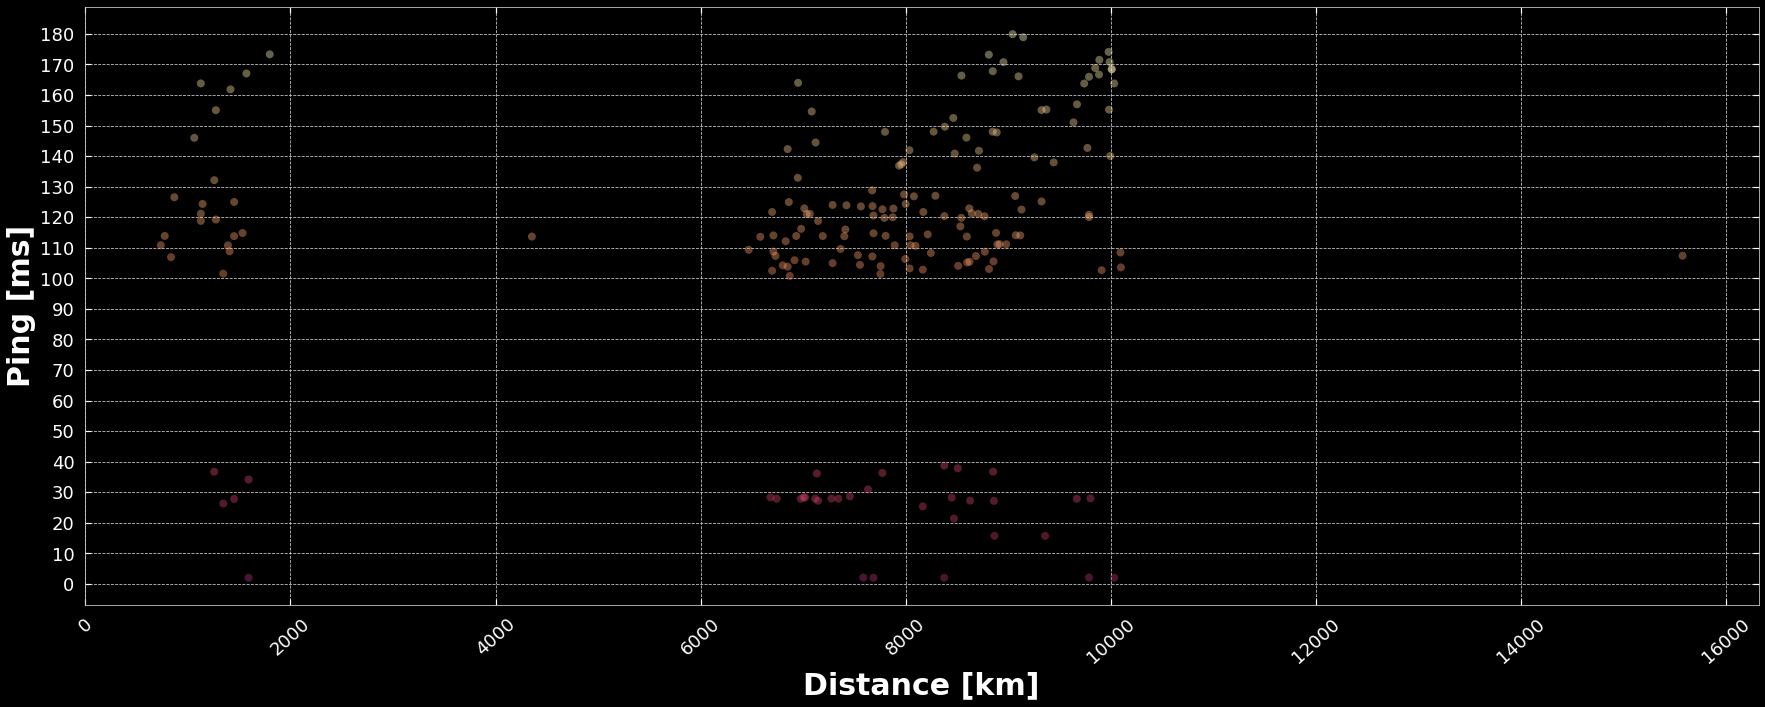

In [384]:
visualize_distance_ping(df=df_f, base=10)

So there are maybe some kind of trend in the data, where the point cloud "tilts to the right", but that's probably just a slightly visual effect. Measuring mostly US universities doesn't yielded us any good results, because most of their networks seems pretty choppy.